In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs

# Set wide fig size for plots
plt.rcParams['figure.figsize']=(12,3)

In [2]:
fpath='Data/WMT.csv'
df=pd.read_csv(fpath)
df.head()

,Date,Adj Close
0,2000-01-03,44.915394
1,2000-01-04,43.234756
2,2000-01-05,42.352402
3,2000-01-06,42.814564
4,2000-01-07,46.049828


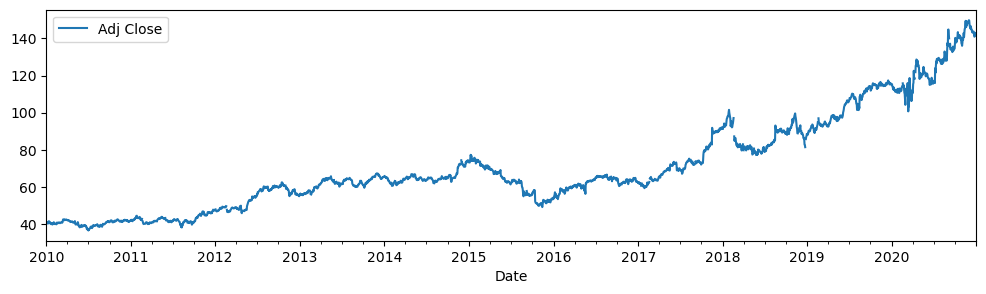

In [3]:
# Make Date a datetime object 
df['Date'] = pd.to_datetime(df['Date'])
# Make Date the index
df = df.set_index('Date')
# Filter for 2010 to 2020 and only the adj close value
ts = df.loc['2010':'2020',:]
ts.plot();

In [4]:
# We have weekly data so we will set our frequency to B
ts=ts.resample('B').asfreq()
# Check for nulls
ts.isna().sum()

Adj Close    101
dtype: int64

In [5]:
# Inspect null values
null = ts['Adj Close'].isna()
ts[null]

,Adj Close
Date,
2010-01-01,NaN
2010-01-18,NaN
2010-02-15,NaN
2010-04-02,NaN
2010-05-31,NaN
...,...
2020-05-25,NaN
2020-07-03,NaN
2020-09-07,NaN


In [6]:
# Fill missing values with previous value
ts = ts.fillna(method='ffill')
ts.isna().sum()

Adj Close    1
dtype: int64

In [7]:
# Inspect null values
null = ts['Adj Close'].isna()
ts[null]

,Adj Close
Date,
2010-01-01,NaN


In [10]:
ts=ts.dropna()
ts.isna().sum()

Adj Close    0
dtype: int64

In [8]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                        '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                        'stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [12]:
#we will convert to a Pandas series.
ts=ts['Adj Close']
get_adfuller_results(ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,stationary?
adfuller,1.436262,23,2845,0.997273,0.05,False


In [13]:
# use ndiffs to determine differencing
d = ndiffs(ts)
print(f'd is {d}')

d is 1


In [14]:
# Difference and check ADF
ts_diff =ts.diff().dropna()
get_adfuller_results(ts_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,stationary?
adfuller,-12.215558,22,2845,0.0,0.05,True


In [15]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

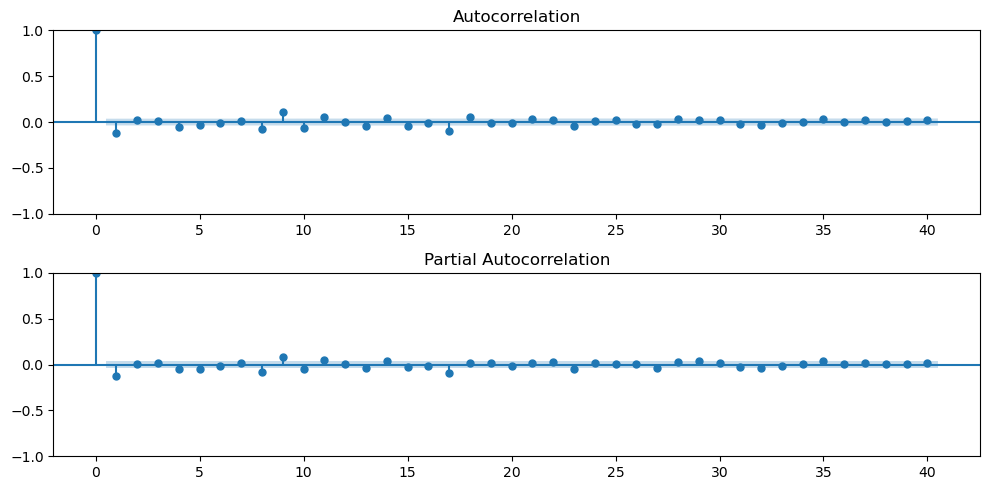

In [17]:
plot_acf_pacf(ts_diff);

## we choose initial time series model orders​ (p,d,q) as (1,1,1)

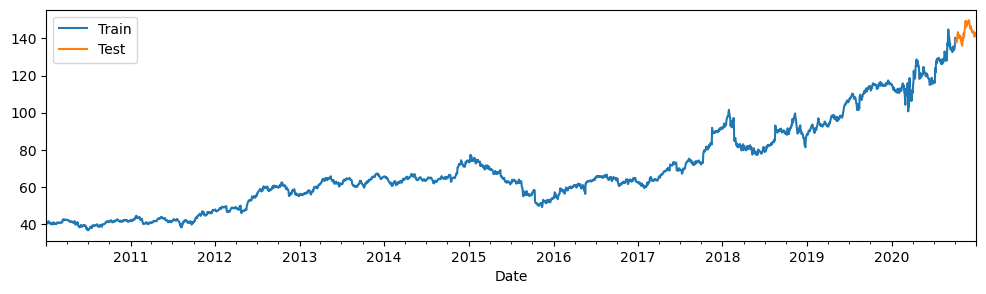

In [18]:
# Calculating number of test lags, one quarter (13 weeks X 5 business days) 
n_test_lags = 5*13

# Modeling to predict 6 months into the future
train, test = train_test_split(ts, test_size=n_test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [23]:
# Build the model 
p = 1  # AR component 

d = 1  # Number of differencing required to make stationary

q = 1  # MA component 

# Define and fit the model
arima_model = tsa.ARIMA(train, order=(p,d,q)).fit()
# Obtain summary of forecast as dataframe
forecast_df = arima_model.get_forecast(len(test)).summary_frame()

In [21]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                    forecast_df['mean_ci_upper'],
                    color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 3.744
- MSE = 22.319
- RMSE = 4.724
- R^2 = -0.736
- MAPE = 2.57%


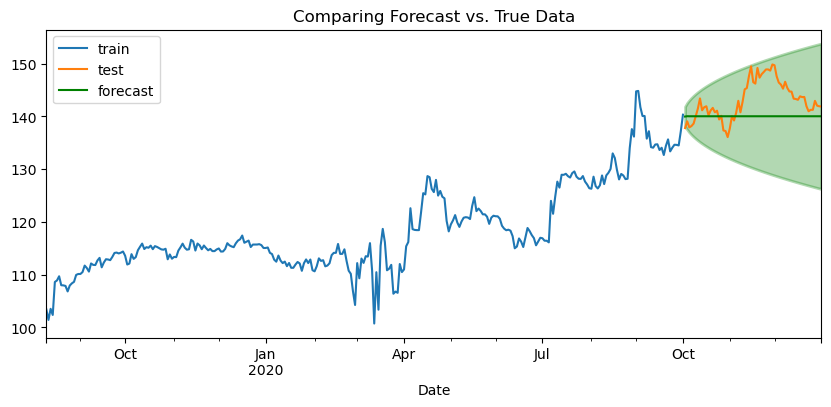

In [27]:
# Plot the forecast with true values
plot_forecast(train, test, forecast_df, n_train_lags=300)

# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [30]:
# Obtain summary of model
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2804
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3887.572
Date:                Fri, 27 Oct 2023   AIC                           7781.144
Time:                        13:36:53   BIC                           7798.959
Sample:                    01-04-2010   HQIC                          7787.574
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1806      0.050     -3.634      0.000      -0.278      -0.083
ma.L1          0.0621      0.052      1.191      0.234      -0.040       0.164
sigma2         0.9380      0.006    146.421      0.000       0.925       0.951
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            113802.52
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):              10.47   Skew:                             0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Notice that the ma.L1 coefficient is NOT significant. Using a loop to try combinations of model orders

In [39]:
import itertools

# Define the value or range of values for p, d, q
p_values = range(0, 3)  
d_values = [1]     
q_values = range(0, 3)  

# Create combinations of pdq to test
pdq_to_try = list(itertools.product(p_values, d_values, q_values))                                   

In [40]:
# define starting aic as infinity
best_aic = float("inf")  

# define baseline for pdq
best_pdq = (0,0,0)

# Loop through each combination
for pdq in pdq_to_try:
    
    model = tsa.ARIMA(train, order=pdq)
                              
    result = model.fit()
    
    print(pdq, result.aic)      
    
    # If lower, replace best AIC with new value
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdq = pdq

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdq:", best_pdq)

(0, 1, 0) 7817.4204384338
(0, 1, 1) 7780.48278476243
(0, 1, 2) 7781.152992998301
(1, 1, 0) 7779.3218305888995
(1, 1, 1) 7781.144092849747
(1, 1, 2) 7781.943450899789
(2, 1, 0) 7781.127658164607
(2, 1, 1) 7783.30202478963


C:\Users\yupfj\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\yupfj\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 2) 7783.305214210703
Best AIC: 7779.3218305888995
Best pdq: (1, 1, 0)


## let's fit an ARIMA(1,1,0) and see how our summary, diagnostic plots, and metrics compare.

In [34]:
# Build the model 
p = 1  # AR component 

d = 1  # Number of differencing required to make stationary

q = 0  # MA component 

# Define and fit the model
arima_model = tsa.ARIMA(train, order=(p,d,q)).fit()
# Obtain summary of forecast as dataframe
forecast_df = arima_model.get_forecast(len(test)).summary_frame()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 3.768
- MSE = 22.546
- RMSE = 4.748
- R^2 = -0.753
- MAPE = 2.59%


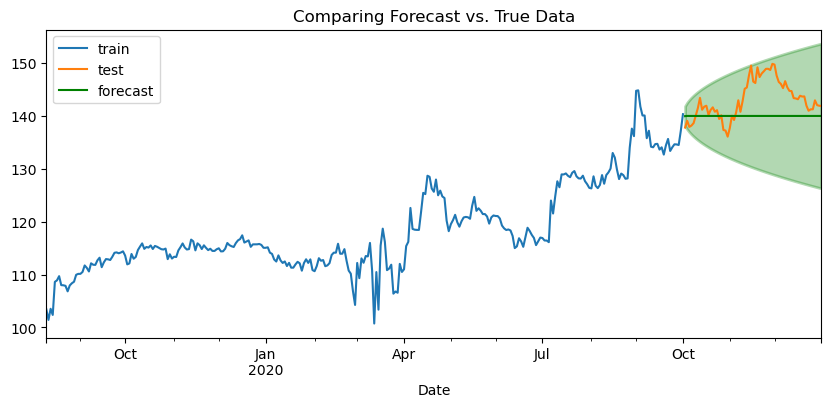

In [35]:
# Plot the forecast with true values
plot_forecast(train, test, forecast_df, n_train_lags=300)

# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

How good was your model, according to your Mean Absolute Percentage Error? 
- MAPE (2.59%) is more than 2% on the test data, not good enough . 

How good was your model in terms of how well the forecast seems to follow the test data, visually?  
- This dataset has many random fluctuations that our model could not predict, but overall, 
we can see that nearly all of the values in our test set fall within the green confidence interval of our predictions.

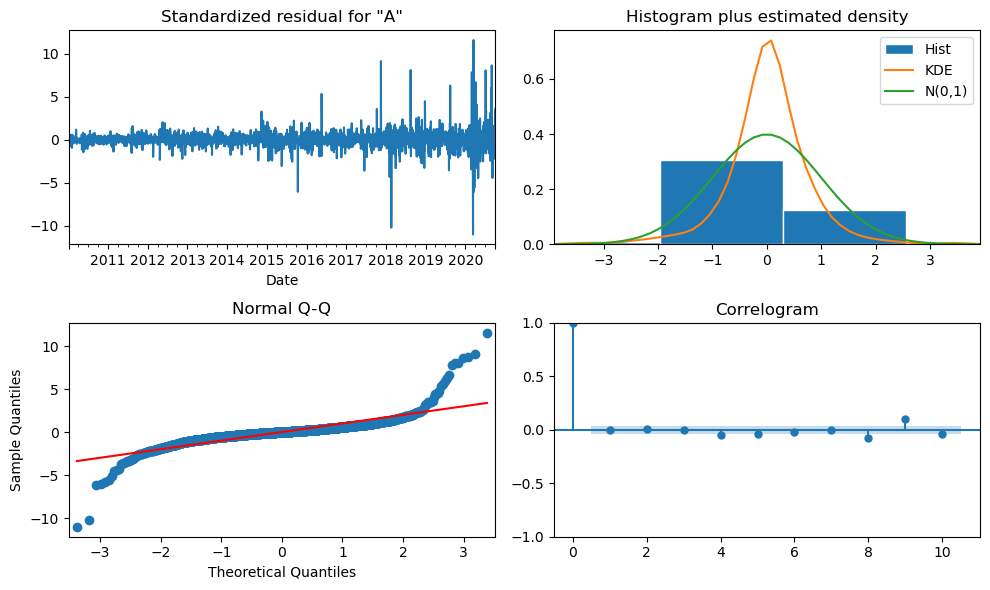

In [41]:
# Obtain diagnostic plots
fig = arima_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

In [42]:
# Obtain summary of model
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2804
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -3887.661
Date:                Fri, 27 Oct 2023   AIC                           7779.322
Time:                        13:59:51   BIC                           7791.199
Sample:                    01-04-2010   HQIC                          7783.609
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1194      0.006    -21.126      0.000      -0.130      -0.108
sigma2         0.9380      0.006    147.429      0.000       0.926       0.951
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            114524.37
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              10.47   Skew:                             0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""